## XGBoostRegressor Models
____
GOALS:
* Model `price_actual` using a univariate XGBRegressor <br>
* Model all price components EXCEPT `price_day_ahead` with a multivariate XGBRegressor
___
OUTLINE:<br>
1. Import Libraries
2. Read in Data
3. Modeling `price_actual`<br>
    3.1 Prepare Data (Categoricals)<br>
    3.2 Split Data<br>
    3.3 Model<br>
    3.4 Refine Model<br>
4. Modeling Price Components (excluding `price_day_ahead`)<br>
    4.1 Model Residual<br>
    4.2 Model Individual Components<br>
5. Final Model <br>
___

### 1. Import Libraries

In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import os



# import split data
os.chdir('../scripts')
from functions import split_data, sMAPE, r2, compute_metrics, plot_metric_range
os.chdir('../notebooks')

### 2. Read in the Data

In [2]:
# Read in data
df_lag = pd.read_csv('../data/clean/df_clean_lag.csv', index_col=0, parse_dates=True)

### Place any functions here

In [3]:
'''def compute_metrics(
    model,
    model_index = None,
    X_train = None,
    y_train = None,
    X_val = None,
    y_val = None,
    results_df = None,
    verbose = False,
    append_result = True):
    
    if isinstance(X_train, pd.DataFrame)  and len(X_train) == len(y_train):
        preds_train = model.predict(X_train)
        if len(preds_train.shape)>1:
            preds_train = preds_train.sum(axis=1)
            y_train = y_train.sum(axis=1)
        sMAPE_train = sMAPE(y_train, preds_train)
        r2_train = np.corrcoef(y_train, preds_train)[0][1]**2
    if isinstance(X_val, pd.DataFrame)  and len(X_train) == len(y_train):
        preds_val = model.predict(X_val)
        if len(preds_val.shape)>1:
            preds_val = preds_val.sum(axis=1)
            y_val = y_val.sum(axis=1)
        sMAPE_val = sMAPE(y_val, preds_val)
        r2_val = np.corrcoef(y_val, preds_val)[0][1]**2

    if verbose:
        print('sMAPE_train:', sMAPE_train)
        print('sMAPE_val:', sMAPE_val)
        print('r2_train:', r2_train)
        print('r2_val:', r2_val)
        
    if model_index == None and append_result:
        model_index = len(results_df)
        
    if append_result:
        results_df.loc[model_index] = [sMAPE_train, sMAPE_val, r2_train, r2_val]
        return results_df'''

"def compute_metrics(\n    model,\n    model_index = None,\n    X_train = None,\n    y_train = None,\n    X_val = None,\n    y_val = None,\n    results_df = None,\n    verbose = False,\n    append_result = True):\n    \n    if isinstance(X_train, pd.DataFrame)  and len(X_train) == len(y_train):\n        preds_train = model.predict(X_train)\n        if len(preds_train.shape)>1:\n            preds_train = preds_train.sum(axis=1)\n            y_train = y_train.sum(axis=1)\n        sMAPE_train = sMAPE(y_train, preds_train)\n        r2_train = np.corrcoef(y_train, preds_train)[0][1]**2\n    if isinstance(X_val, pd.DataFrame)  and len(X_train) == len(y_train):\n        preds_val = model.predict(X_val)\n        if len(preds_val.shape)>1:\n            preds_val = preds_val.sum(axis=1)\n            y_val = y_val.sum(axis=1)\n        sMAPE_val = sMAPE(y_val, preds_val)\n        r2_val = np.corrcoef(y_val, preds_val)[0][1]**2\n\n    if verbose:\n        print('sMAPE_train:', sMAPE_train)\n       

In [4]:
def r2(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0][1]**2

In [5]:
def compute_metrics(model, train, test):
        
    preds_train = model.predict(train[0])
    preds_test = model.predict(test[0])
    
    sMAPE_train = sMAPE(train[1], preds_train)
    sMAPE_val = sMAPE(test[1], preds_test)

    r2_train = r2(train[1], preds_train)
    r2_val = r2(test[1], preds_test)
    
    return [sMAPE_train, sMAPE_val, r2_train, r2_val]

In [6]:
def set_param(model, param, value):
    if param == 'max_depth':
        model.set_params(max_depth=value)
    if param == 'gamma':
        model.set_params(gamma=value)
    if param == 'min_child_weight':
        model.set_params(min_child_weight=value)
    if param == 'subsample':
        model.set_params(subsample=value)
    if param == 'colsample_bytree':
        model.set_params(colsample_bytree=value)
    if param == 'reg_alpha':
        model.set_params(reg_alpha=value)
    if param == 'reg_lambda':
        model.set_params(reg_lambda=value)
    model.set_params(random_state=17)
    return model


def plot_metric_range(model, train, test, param, range_):
    #Create lists to hold metrics for plotting
    sMAPE_train, sMAPE_val, r2_train, r2_val = [],[],[],[]
    
    # For each element in metric range, fit model, compute metrics, and add to respective lists
    for i in range_:
        x = model
        
        x = set_param(x, param, i)
        
        x.fit(X_train, y_train)
        metrics = compute_metrics(x, 'None',(train[0], train[1]), (test[0], test[1]))
        sMAPE_train.append(metrics[1])
        sMAPE_val.append(metrics[2])
        r2_train.append(metrics[3])
        r2_val.append(metrics[4])
    
    # Plot the metrics, one plot for train, one for test
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].plot(range_, sMAPE_train, label='sMAPE_train')
    ax[0].plot(range_, sMAPE_val, label='sMAPE_val');
    ax[0].set(xlabel=f'{param}', ylabel='sMAPE score', title=f'{param} versus sMAPE');
    ax[0].legend();
    ax[1].plot(range_, r2_train, label='r2_train');
    ax[1].plot(range_, r2_val, label='r2_val');
    ax[1].legend();
    ax[1].set(xlabel=f'{param}', ylabel='r2 score', title=f'{param} versus r2');
    

### 3. Modeling `price_actual`

### 3.1 Data Preparation - Encode Categoricals
___
In preparation for XGBRegressor, categorical columns will have to be label encoded. The categorical data to encode include wind directions and basic weather conditions, but for each of the five cities we have data from.  

**wind_dir_encoder**: Since there's a limited amount of wind directions, we should be able to fit the encoder on a single city's wind column and apply that encoder to the rest of the wind direction columns.

**condition_encoder**: Since there are lots of different weather conditions, we'll have to get all the wind condition columns and stack them first. Then fit the encoder to the stacked conditions, then apply the coder to the condition column of each city.
___

In [3]:
# Get Categorical columns
categorical = df_lag.select_dtypes(include='object')

# Instationate wind_dir_coder LabelEncoder, fit
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df_lag['wind_madrid_lag'])

# Transform wind_direction cols
for col in categorical.filter(regex='wind').columns:
    df_lag[col] = wind_dir_coder.transform(df_lag[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate condition_coder LabelEncoder, fit on stacked conditions
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)

# Transform condition cols
for col in categorical.filter(regex='condition').columns:
    df_lag[col] = condition_coder.transform(df_lag[col])

### 3.2 Data Preparation - Train/Validation Split
___
Modeling`price_actual`:
* Drop all price component columns other than `price_actual`
* Split data into train/validation/testing sets
___

In [4]:
# Get price cols to remove
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]
price_cols.remove('price_day_ahead')

# Create dataset without price cols to remove, split data
data = df_lag.drop(columns=price_cols)
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_actual')

### 3.3 Data Preparation - Create results_actual DataFrame
___
It will be handy to store each model's results/metrics in a single dataframe for comparison, I'll call it `results_actual`.

**METRICS**
* <u>sMAPE</u>: Will be used as the primary metric for comparison.  sMAPE was selected over MAPE since MAPE is asymetrical. Predictions that are too low cannot exceed 100% while predictions that are too high have no upper limit.
* <u>r2</u>: Will be calculated along with sMAPE, however, it is not expected that r2 will improve significantly since predictions from the TSO (`price_day_ahead`) already acheive r2 greater than 0.97.
___

In [5]:
results_actual = pd.DataFrame(index=['Parameters','SMAPE_train', 'SMAPE_val', 'r2_train', 'r2_val'])
results_actual['TSO'] = ['None',
                         round(sMAPE(y_train, df_lag.loc[:'2019', 'price_day_ahead']), 3),
                         round(sMAPE(y_val, df_lag.loc['2020', 'price_day_ahead']), 3),
                         round(r2(y_train, df_lag.loc[:'2019', 'price_day_ahead']), 3), 
                         round(r2(y_val, df_lag.loc['2020', 'price_day_ahead']),3)]
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971



Modeling all price components (except `price_day_ahead`)
* Get `price_actual` and `price_day_ahead` in another variable, remove from the predictors
* Split data intoo train/validation/testing sets

### 3.4 Modeling `price_actual`

In [6]:
# Instantiate and fit XGBRegressor
xg = XGBRegressor(random_state=17)
xg.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['XGBoost'] = compute_metrics(xg, 'Vanilla',(X_train, y_train), (X_val, y_val))
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
XGBoost,Vanilla,1.248,6.668,0.996,0.968


`x1` reduced sMAPE_val to 2.5 times less than the TSO prediction, r2_val were about the same.  The model is looks well-fit too. Lets play with the `max_depth` parameter (default=6) and see if we can increase the performance at all.  Next I'll explore by fitting new models with `max_depth` ranging from 1-20. I'll plot the resulting metrics and investigate.

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


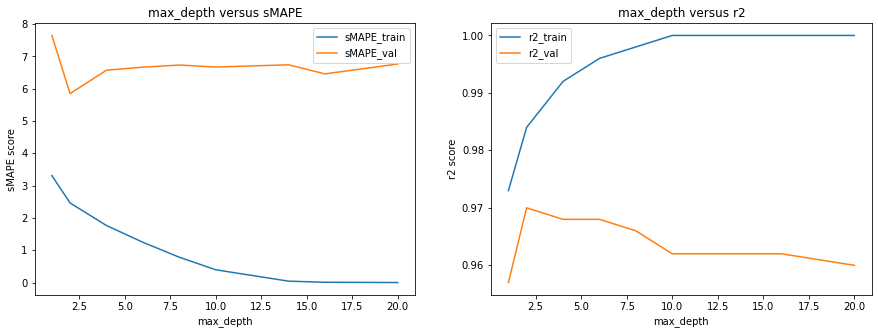

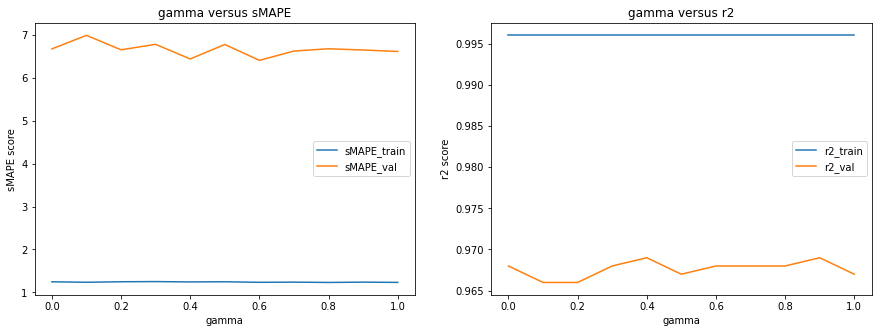

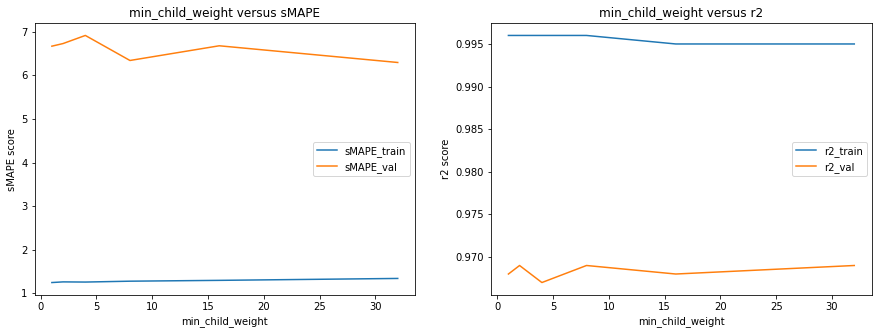

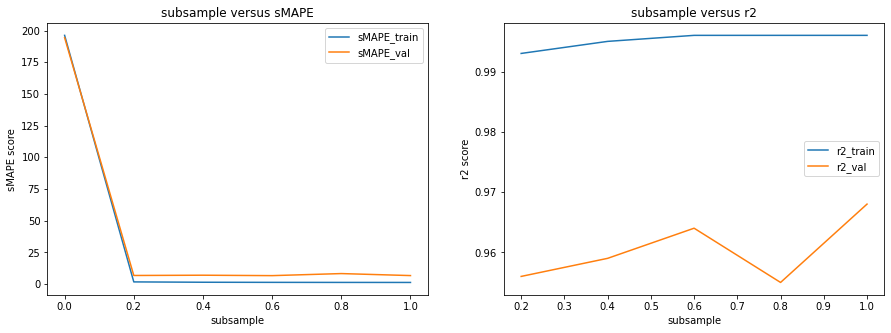

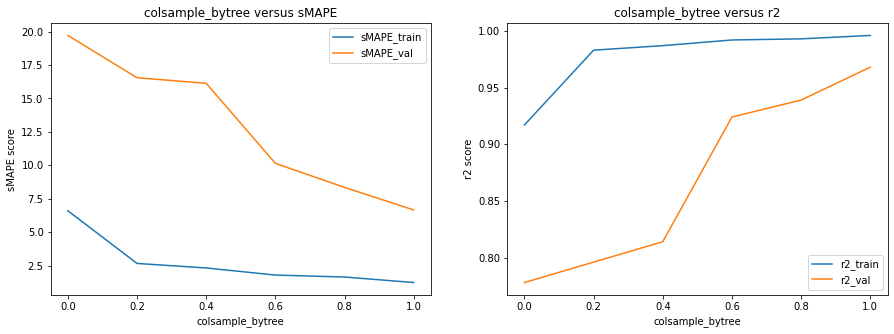

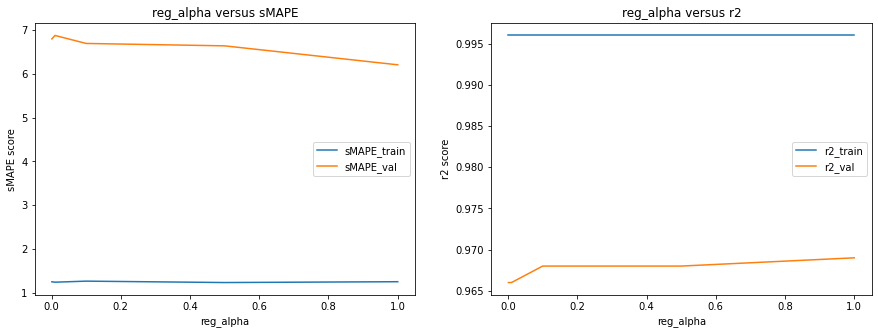

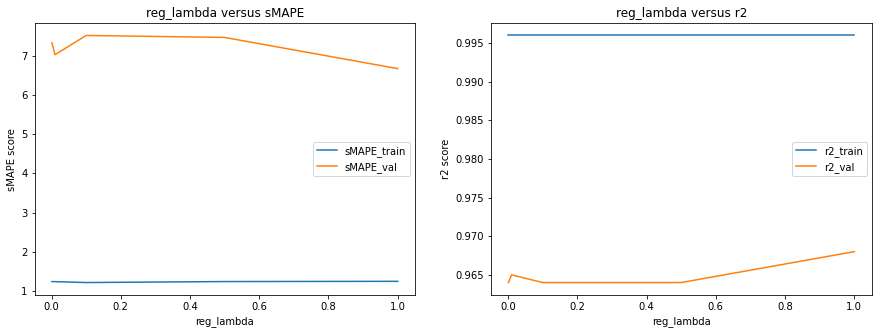

In [7]:
# Create dictionary to map param ranges to their parameters
xgb_params = {
    'max_depth': [1,2,4,6,8,10,14,16,20],
    'gamma': [n/10 for n in range(11)],
    'min_child_weight': [1,2,4,8,16,32],
    'subsample': [n/10 for n in range(0, 12, 2)],
    'colsample_bytree': [n/10 for n in range(0, 12, 2)],
    'reg_alpha': [.001, .01, .1, .5, 1],
    'reg_lambda': [.001, .01, .1, .5, 1]
}

# For each parameter and its respective range, plot the metrics
for param in xgb_params.keys():
    plot_metric_range(XGBRegressor(), (X_train, y_train), (X_val, y_val), param, xgb_params[param])

Adjusting all of these parameters in their respective ranges, there really isn't much improvement in either of the metrics sMAPE nor r2. The one exception may be `max_depth` which did see minor improvement in SMAPE when reduced set to 2.

In [8]:
# Instantiate and fit XGBRegressor
xg1 = XGBRegressor(random_state=17, max_depth=2)
xg1.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['XGBoost1'] = compute_metrics(xg1, {'max_depth':2},(X_train, y_train), (X_val, y_val))
results_actual

,TSO,XGBoost,XGBoost1
Parameters,None,Vanilla,{'max_depth': 2}
SMAPE_train,16.03,1.248,2.465
SMAPE_val,16.922,6.668,5.85
r2_train,0.954,0.996,0.984
r2_val,0.971,0.968,0.97


Let's look at the feature importances for xg1.

In [10]:
imp = pd.DataFrame({'importance':xg1.feature_importances_},
                   index=X_train.columns).sort_values(by='importance', ascending=False)
imp.head(10)

,importance
price_day_ahead,0.735356
biomass_lag,0.046353
renewable_lag,0.037915
load_forecast,0.035208
coal_lag,0.034028
waste_lag,0.020222
transmission_fs_lag,0.008342
dew_point_seville_lag,0.007706
solar_lag,0.006477
reservoir_lag,0.006204


Feature `price_day_ahead` is without a doubt the most important feature.  It would be good to investigate how our model would do without it.  Let's remove `'price_day_ahead` from the predictors and rerun the model.  I'll also reset `max_depth` to the default since this model may underfit without it's most informative feature.

In [11]:
# Get price cols to remove
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]

# Create dataset without price cols to remove, split data
data = df_lag.drop(columns=price_cols)
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_actual')

In [13]:
# Instantiate and fit XGBRegressor
xg2 = XGBRegressor(random_state=17)
xg2.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['XGBoost2'] = compute_metrics(xg2,
                                        {'price_day_ahead':False},
                                        (X_train, y_train),
                                        (X_val, y_val))
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,{'price_day_ahead': False},4.331,27.241,0.953,0.427


max_depth complete
gamma complete
min_child_weight complete


C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


subsample complete
colsample_bytree complete
reg_alpha complete
reg_lambda complete


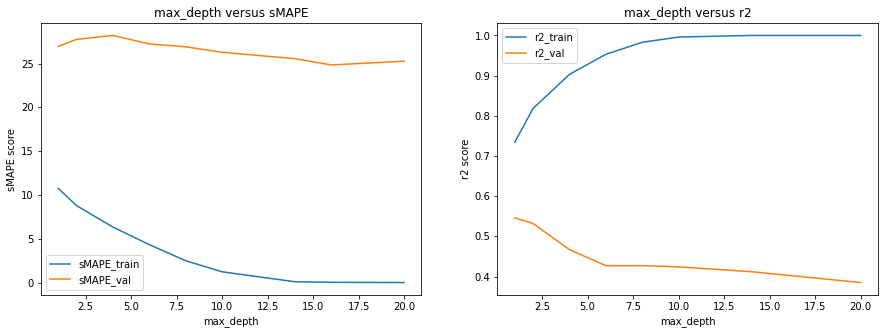

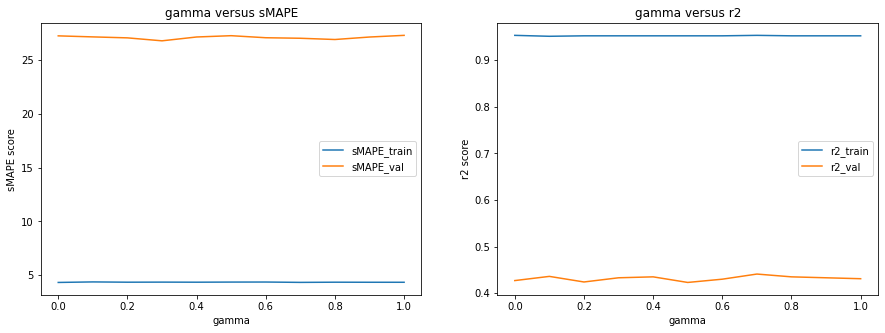

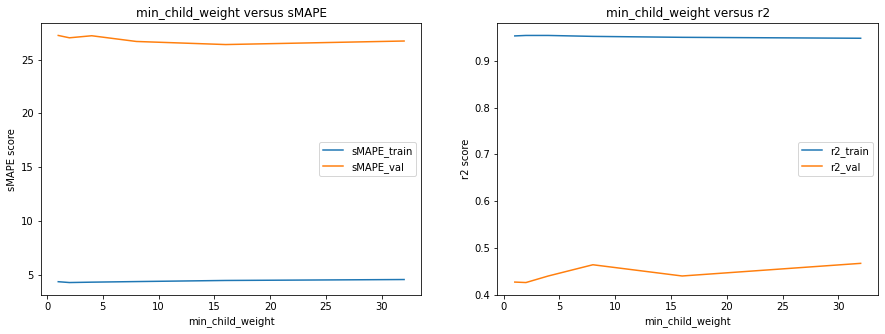

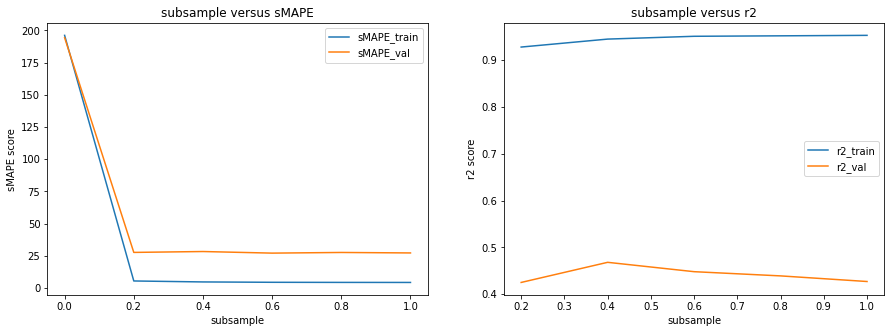

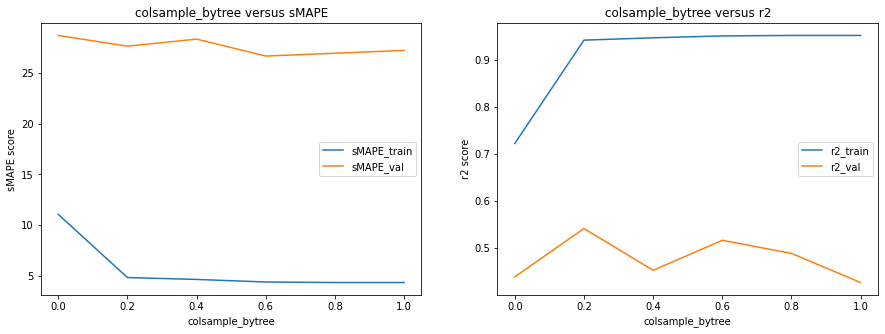

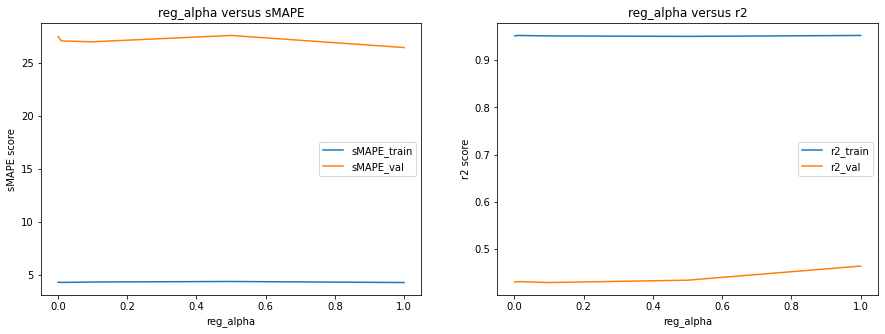

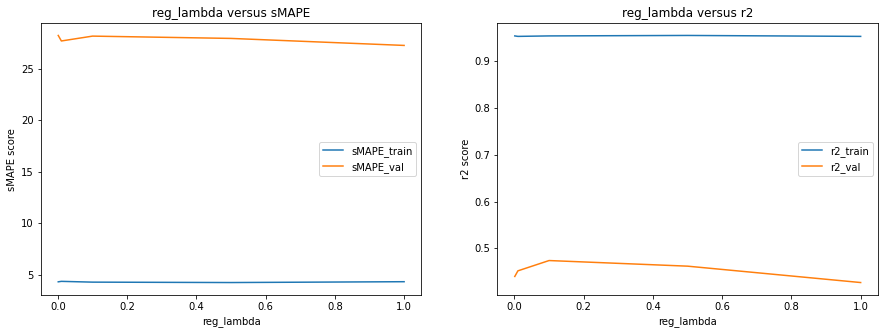

In [14]:
# Create dictionary to map param ranges to their parameters
xgb_params = {
    'max_depth': [1,2,4,6,8,10,14,16,20],
    'gamma': [n/10 for n in range(11)],
    'min_child_weight': [1,2,4,8,16,32],
    'subsample': [n/10 for n in range(0, 12, 2)],
    'colsample_bytree': [n/10 for n in range(0, 12, 2)],
    'reg_alpha': [.001, .01, .1, .5, 1],
    'reg_lambda': [.001, .01, .1, .5, 1]
}

# For each parameter and its respective range, plot the metrics
for param in xgb_params.keys():
    plot_metric_range(XGBRegressor(), (X_train, y_train), (X_val, y_val), param, xgb_params[param])
    print(param + ' complete')

Again, tuning these parameters did not change our metrics in a substantial way.  `Max_depth` was the only parameter that made a difference in SMAPE, and even then the difference was minor.  Let's run another model qith `max_depth` set to 16 and add it to the results table.

In [22]:
# Instantiate and fit XGBRegressor
xg3 = XGBRegressor(random_state=17, max_depth=16)
xg3.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_actual['XGboost3'] = compute_metrics(xg3,
                                             {'price_day_ahead':False, 'max_depth':16},
                                             (X_train, y_train),
                                             (X_val, y_val))
results_actual.T

,Parameters,SMAPE_train,SMAPE_val,r2_train,r2_val
TSO,None,16.03,16.922,0.954,0.971
XGBoost,Vanilla,1.248,6.668,0.996,0.968
XGBoost1,{'max_depth': 2},2.465,5.85,0.984,0.97
XGBoost2,{'price_day_ahead': False},4.331,27.241,0.953,0.427
XGboost3,"{'price_day_ahead': False, 'max_depth': 16}",0.026,24.84,1.0,0.403


Even after adjusting all the XGBoost pruning parameters, it appears the model does not improve and is grossly overfit.  Without `price_day_ahead` the features are having a really hard time predicting `price_actual`.

**Since `price_day_ahead` is significantly more important than any other feature in predicting actual price, are any of these other features helping much at all?**

### 4. Modeling Price Components (excluding `price_day_ahead`)
**Method 1**:<br>
To figure out if our predictors (excluding `price_day_ahead`) are helping predict the `price_actual`, let's model the residual of `price_actual` - `price_day_ahead`.  This residual represents the portion of `price_actual` not reflected in `price_day_ahead`. If we are able to model the residual, we could add the predictions from our model to `price_day_ahead` to improve our predictions for `price_actual`.

**Method 2**:<br>
Another method in modeling the components is to literally model each price component (besides `price_day_ahead`) individually. With predictions for each component by the hour, we could add up the price component predictions, along with `price_day_ahead` to come up with a final price.

### 4.1 Modeling price_actual residual
___
* Create price_residual
* Drop other price columns
* Split the data into training and validation data
___

In [13]:
# Get price cols to predict
price_cols = df_lag.filter(regex='price').columns.to_list()

# Create price_residual
data = df_lag.copy()
data['price_residual'] = data['price_day_ahead'] - data['price_actual']

# Drop other price cols, and split data
data.drop(columns = price_cols, inplace=True)
X_train, y_train, X_val, y_val = split_data(data, 2020, 'price_residual')

Now, we'll set up a results dataframe and run the first model.

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(43800, 59)
(43800,)
(8784, 59)
(8784,)


In [18]:
# Create results table
results_resid = pd.DataFrame(index=['Parameters','sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Instantiate and fit XGBRegressor
x_resid1 = XGBRegressor(random_state=17)
x_resid1.fit(X_train, y_train)

# Compute sMAPE, r2 and add to the table
results_resid['x_resid1'] = compute_metrics(x_resid1, 'None', (X_train, y_train), (X_val, y_val))
results_resid

,x_resid1
Parameters,None
sMAPE_train,9.025249
sMAPE_val,35.370161
r2_train,0.927338
r2_val,0.173706


As shown above, the model is very overfit on the training set.  Let's see if increasing/decreasing the max_depth will change increase/decrease the performance.

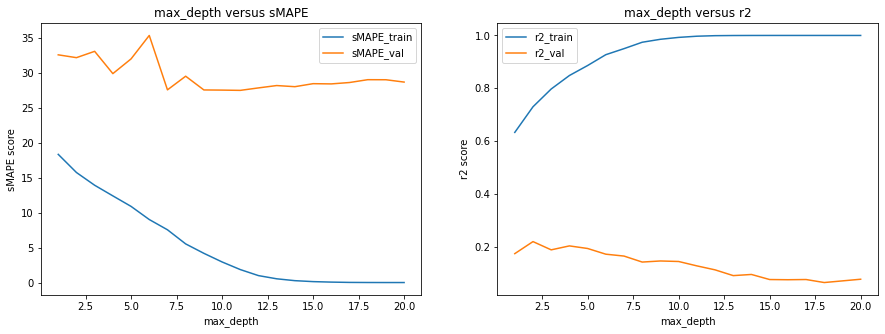

In [276]:
# Create dictionary to map param ranges to their parameters
xgb_params = {'max_depth': range(1,21,1)}

# For each parameter and its respective range, plot the metrics
for param in xgb_params.keys():
    plot_metric_range(XGBRegressor(random_state=17), (X_train, y_train),
                      (X_val, y_val), param, xgb_params[param])

Changing the tree depth only did decreased the testing sMAPE but it did not help with our overfitting issue.  Let's run through the same ranges of tree pruning/regularization techniques as before to see if we can appropriately fit the model.

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


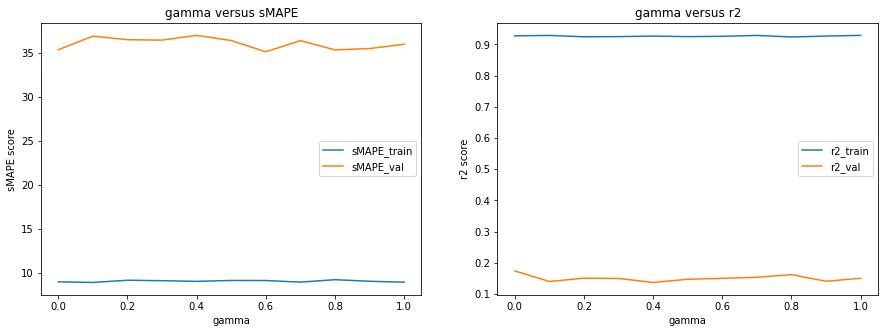

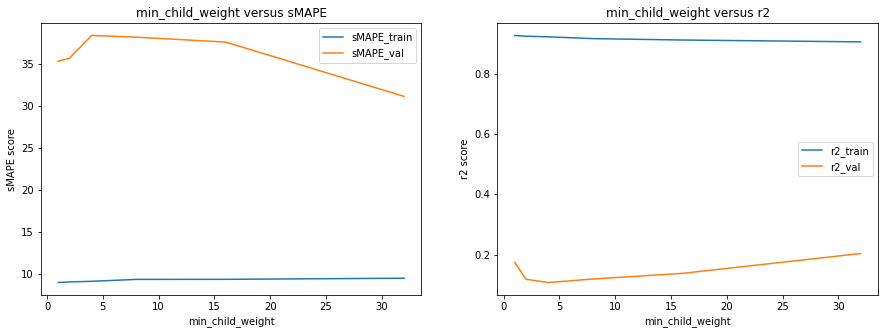

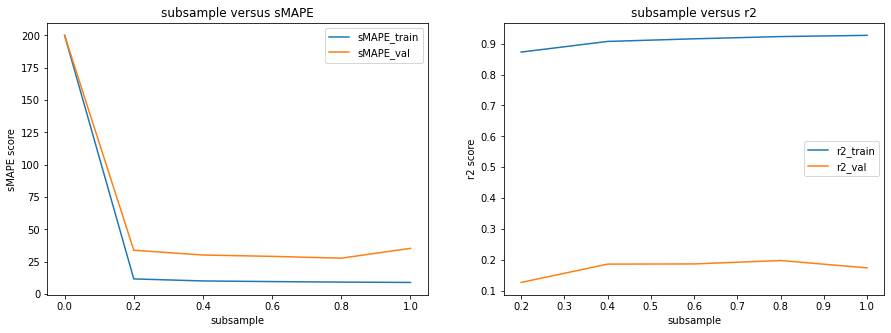

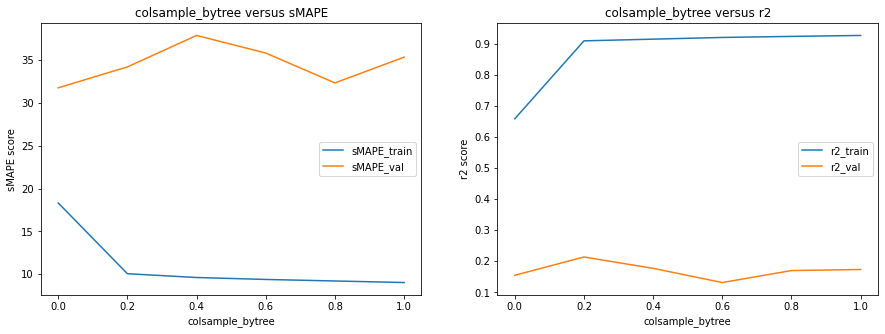

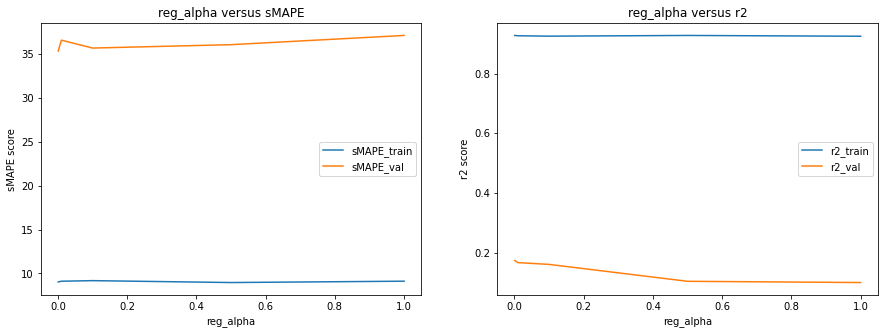

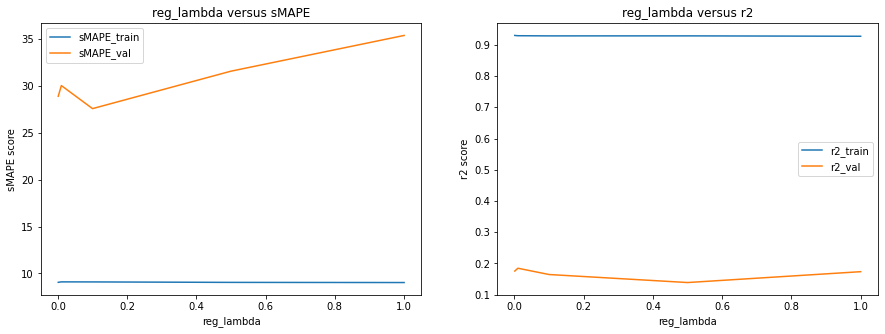

In [19]:
xgb_params = {
    'gamma': [n/10 for n in range(11)],
    'min_child_weight': [1,2,4,8,16,32],
    'subsample': [n/10 for n in range(0, 12, 2)],
    'colsample_bytree': [n/10 for n in range(0, 12, 2)],
    'reg_alpha': [.001, .01, .1, .5, 1],
    'reg_lambda': [.001, .01, .1, .5, 1]
}

# For each parameter and its respective range, plot the metrics
for param in xgb_params.keys():
    plot_metric_range(XGBRegressor(random_state=17), (X_train, y_train),
                      (X_val, y_val), param, xgb_params[param])

Looks like the model had an extremely hard time fitting on the residual.  Maybe the data really doesn't say anything about the combined components of price (minus `price_day_ahead`).

Let's move to the second option and see the data says anything about each component individually.  Here, I'll set up a model to predict each component. To begin, set up y_cols to include only the price components (exclude `price_day_ahead`).

In [20]:
# Get price cols to predict
price_cols = df_lag.filter(regex='price').columns.to_list()[1:]
price_cols.remove('price_day_ahead')

# Drop other price cols, and split data
data = df_lag.drop(columns=['price_day_ahead', 'price_actual'])
X_train, y_train, X_val, y_val = split_data(data, 2020, price_cols)

* `MultiOutputRegressor` which runs and stores a new model for each target
* Fit the new models for each target
* Run the predictions

In [21]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17)
x_multi = MultiOutputRegressor(xg_multi)

# Fit the Regressor
x_multi.fit(X_train, y_train);

# Get the predictions
preds_train = x_multi.predict(X_train)
preds_val = x_multi.predict(X_val)


To see the results, I'll set up a results_comp dataframe.  For each model in x_multi, I'll use the compute metric function to add the compute metrics to the table and output it below.

In [22]:
# Create results table
results_comp = pd.DataFrame(index=['Parameters', 'sMAPE_train', 'sMAPE_val', 'r2_train', 'r2_val'])

# Add metric results to results table
for i, model in enumerate(x_multi.estimators_):    
    results_comp[y_val.columns[i]] = compute_metrics(model, 'None', (X_train,y_train.iloc[:,i]), (X_val, y_val.iloc[:,i]))
results_comp.T.sort_values(by='sMAPE_val')

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
price_power_factor,None,2.435117,16.293799,0.970552,0.130353
price_capacity_payment,None,11.404629,38.368313,0.957103,0.573261
price_PBF_tech,None,22.812612,40.881838,0.933131,0.470719
price_sec_reserve,None,25.511023,58.703187,0.873666,0.297368
price_measured_imbalances,None,74.215783,94.99665,0.843589,0.001585
price_imbalances_net,None,107.657609,128.049893,0.655338,0.001148
price_balance_failure,None,127.367726,139.903382,0.646287,0.000866
price_intraday_market,None,115.229651,142.530756,0.675297,0.006006
price_P0146_balance,None,123.288978,148.703862,0.514304,0.001695
price_rt_tech,None,155.138772,172.340196,0.743252,0.016256


This table give a good look at how the model did by each component.  First to note, there are NaNs present in some of the r2 calculations.  The presence of NaNs and the warning above mean that we were dividing by zero at some point in the calcatulation - the relationship between the predictions and this particular component do not exist.  Second, while there is over-fitting going on for many of these components, it appears less over fit than when we had modeled the price residual.  We did actual obtain a decent sMAPE for `price_power_factor` components. Let's sort by r2 and see which components were best modeled with the data.

In [23]:
results_comp.T.sort_values(by='r2_val', ascending=False).head(4)

,Parameters,sMAPE_train,sMAPE_val,r2_train,r2_val
price_capacity_payment,None,11.404629,38.368313,0.957103,0.573261
price_PBF_tech,None,22.812612,40.881838,0.933131,0.470719
price_sec_reserve,None,25.511023,58.703187,0.873666,0.297368
price_power_factor,None,2.435117,16.293799,0.970552,0.130353


The above shows the best r2 validation results by components. These components as expected also received the best sMAPE scores. The model may have some information pertaining to these individual components.  Just quickly, lets look at the feature importances for these components.

All the predictions are stored inside `preds_train`, and `preds_val`.  I'll extract these predictions with nested dictionaries then reformat them into dataframes for display

In [25]:
# Components to investigate: top 5 sMAPE components
top_modeled = results_comp.T.sort_values(by='sMAPE_val', ascending=False).head(4).index

# Get importance by component dict {x_cols:feature_importances}}
imp_by_comp = [
    dict(zip(X_val.columns, x_multi.estimators_[i].feature_importances_)) for i in range(len(x_multi.estimators_))
]

# Zip imp_by_comp into importance {y_components:{x_cols:feature_importances}}
importances = dict(zip(y_val.columns, imp_by_comp))

# Reformat into dataframe for viewing
x_multi_importances = pd.DataFrame(index = importances['price_intraday_tech'].keys(), columns= importances.keys())
for i in X_val.columns:
    for col in y_val.columns:
        x_multi_importances.loc[i, col] = importances[col][i]
x_multi_importances[top_modeled]

,price_intraday_tech,price_upward_reserve,price_generic_failure,price_interupt_service
temp_madrid_lag,0.0,0.016554,0.0,0.001013
dew_point_madrid_lag,0.0,0.006752,0.0,0.004061
humidities_madrid_lag,0.0,0.00907,0.0,0.004645
wind_madrid_lag,0.0,0.006899,0.0,0.000541
wind_speeds_madrid_lag,0.0,0.007161,0.0,0.001442
pressures_madrid_lag,0.0,0.069021,0.0,0.003836
condition_madrid_lag,0.0,0.006766,0.0,0.000891
temp_seville_lag,0.0,0.008864,0.0,0.003028
dew_point_seville_lag,0.0,0.009514,0.0,0.003237
humidities_seville_lag,0.0,0.040388,0.0,0.006486


In [26]:
# For each of the best_modeled components, print out any feature importance greater than .1
for col in top_modeled:
    important = x_multi_importances.loc[abs(x_multi_importances[col])>.1, col].sort_values(ascending=False)
    if len(important) > 0:
        print(col)
        for i in important.index:
            print(i+':', important[i])
        print()

price_intraday_tech
humidities_bilbao_lag: 0.55966157
poundage_lag: 0.43711734

price_interupt_service
coal_lag: 0.24452884
renewable_lag: 0.1263257



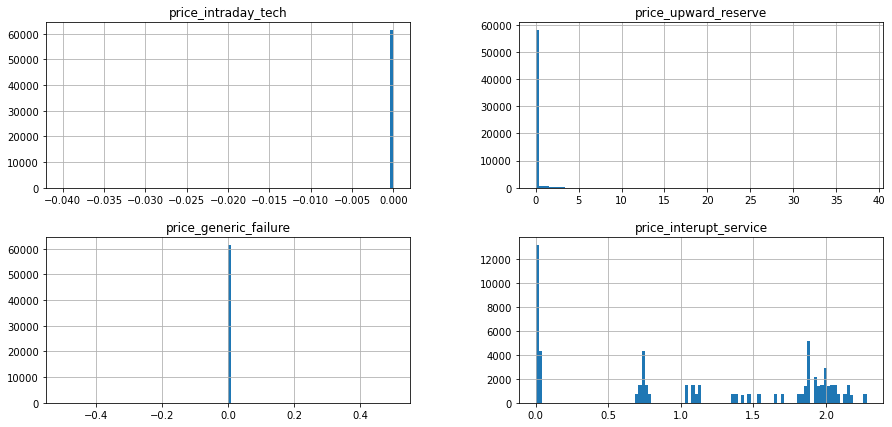

In [27]:
df_lag[top_modeled].hist(bins=100, figsize=(15,7));

In [330]:
print(df_lag.price_intraday_tech.value_counts(),'\n')
print(df_lag.price_generic_failure.value_counts())

 0.00    61342
-0.04        1
-0.02        1
Name: price_intraday_tech, dtype: int64 

0.0    61344
Name: price_generic_failure, dtype: int64


In [40]:
# Instantiate XGBRegressor and Multioutput Regressor
xg_multi = XGBRegressor(random_state=17)
x_multi = MultiOutputRegressor(xg_multi)

# Fit the Regressor
x_multi.fit(X_train, y_train[top_modeled]);

# Get the predictions
preds_train = x_multi.predict(X_train)
preds_val = x_multi.predict(X_val)

# Add predictions to price_day_ahead
preds_train = preds_train.sum(axis=1) + df_lag.loc[:'2019', 'price_day_ahead']
preds_val = preds_val.sum(axis=1) + df_lag.loc['2020', 'price_day_ahead']

# Add results to results dataframe
results_actual['xg5'] = ['None',
                         sMAPE(df_lag.loc[:'2019', 'price_actual'], preds_train),
                         sMAPE(df_lag.loc['2020', 'price_actual'], preds_val),
                         r2(df_lag.loc[:'2019', 'price_actual'], preds_train),
                         r2(df_lag.loc['2020', 'price_actual'], preds_val)]
results_actual

,TSO_prediction,xg1,xg2,xg3,xg4,xg5
Parameters,None,None,{'max_depth': 2},{'price_day_ahead': False},"{'price_day_ahead': False, 'max_depth': 16}",None
sMAPE_train,16.03,1.247603,2.464743,4.331078,0.026319,12.1483
sMAPE_val,16.922,6.668116,5.850279,27.240879,24.84034,13.78994
r2_train,0.954,0.996021,0.984117,0.952814,0.999997,0.963954
r2_val,0.971,0.967929,0.970345,0.427341,0.402667,0.972749
